## DCGAN on MNIST

#### import necessary packages

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import math
import time
import numpy as np


#### Gnerator and Discriminator

In [3]:
# Hyperparameters
latent_dim = 100
img_size = 32
batch_size = 64
epochs = 50
lr = 0.0002

class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, img_size * img_size),
            nn.Tanh()
        )
        self.img_size = img_size

    def forward(self, input):
        return self.main(input).view(-1, 1, self.img_size, self.img_size)

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(img_size * img_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.img_size = img_size

    def forward(self, input):
        return self.main(input.view(-1, self.img_size * self.img_size))

## Train MINIST on vanilla DCGAN

In [4]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizers
generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

In [6]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
generator.load_state_dict(torch.load("out\DCGAN\generator_2"))
discriminator.load_state_dict(torch.load("out/DCGAN/discriminator_2"))


torch.manual_seed(0)
fixed_noise = torch.randn(batch_size, latent_dim).to(device)

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        cur_batch_size =len(real_images)
        real_labels = torch.ones(cur_batch_size, 1).to(device)
        fake_labels = torch.zeros(cur_batch_size, 1).to(device)

        # Train discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        
        noise = torch.randn(cur_batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train generator
        generator.zero_grad()
        noise = torch.randn(cur_batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)

        g_loss.backward()
        optimizer_g.step()

        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )

    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        save_image(fake_images, f"out/DCGANimages/origin_fake_image_each_epoch/{epoch + 51}.png", normalize=True)

torch.save(generator.state_dict(), "out/DCGAN/generator_2")
torch.save(discriminator.state_dict(), "out/DCGAN/discriminator_2")



[Epoch 0/50] [Batch 0/938] [D loss: 0.5062025785446167] [G loss: 2.6622867584228516]
[Epoch 0/50] [Batch 100/938] [D loss: 0.5067003965377808] [G loss: 2.479288101196289]
[Epoch 0/50] [Batch 200/938] [D loss: 0.5955751538276672] [G loss: 2.991755962371826]
[Epoch 0/50] [Batch 300/938] [D loss: 0.5420863032341003] [G loss: 2.7288284301757812]
[Epoch 0/50] [Batch 400/938] [D loss: 0.6085622310638428] [G loss: 2.9099302291870117]
[Epoch 0/50] [Batch 500/938] [D loss: 0.8317247629165649] [G loss: 1.7913525104522705]
[Epoch 0/50] [Batch 600/938] [D loss: 0.7655661106109619] [G loss: 2.4417335987091064]
[Epoch 0/50] [Batch 700/938] [D loss: 0.5147582292556763] [G loss: 2.6113059520721436]
[Epoch 0/50] [Batch 800/938] [D loss: 0.49981626868247986] [G loss: 2.249626636505127]
[Epoch 0/50] [Batch 900/938] [D loss: 0.7007791996002197] [G loss: 2.134763479232788]
[Epoch 1/50] [Batch 0/938] [D loss: 0.996585488319397] [G loss: 1.609630823135376]
[Epoch 1/50] [Batch 100/938] [D loss: 0.400168716907

## Reimplement method 3 in the third paper


$ G^*, w^*=\underset{G, w}{\operatorname{\argmax}} (L_{\text{edit}} + L_{\text{GAN}})$

$  L_{\text{edit}} = G(z + \alpha w) - \text{edit}(G(z), \alpha) $

$ L_{\text{GAN}} = \max_D \left( E_{z,\alpha} \left[ D\left(G(z + \alpha w)\right) \right] - E_{x,\alpha} \left[ D\left(\text{edit}(x, \alpha)\right) \right] \right) $


I hypothesize that an efficient strategy could involve initially training a Generative Adversarial Network (GAN) to generate realistic data and then utilizing transfer learning to adapt the pre-trained GAN model for edit editing dataset. This two-step approach may potentially expedite the training process and enhance performance on the editing task

#### Walk Module

In [43]:
class LinearWalk(nn.Module):
    def __init__(self, input_size = 100):
        super(LinearWalk, self).__init__()
        # Initialize bias as a learnable parameter
        self.bias = nn.Parameter(torch.randn(1, input_size))

    def forward(self, x, alpha):
        # Add the bias to each input with the corresponding alpha

        y = x + self.bias * alpha
        return y

In [33]:
class LinearWalk(nn.Module):
    def __init__(self, input_size = 100):
        super(LinearWalk, self).__init__()
        # Initialize bias as a learnable parameter
        self.fc1 = nn.Linear(input_size, input_size)

    def forward(self, x):
        # Add the bias to each input with the corresponding alpha

        step1 = self.fc1(x)
        return step1

In [29]:
# write a function that edit a batch of image
# The code I wrote for stylegan is not reusable here. I am bad at coding QQ
FILL_VALUE = -0.95
def rotate(img, alpha, max_degree=45):
    return transforms.functional.rotate(img=img, angle=alpha * max_degree, fill = FILL_VALUE)

def shift(img, alpha, max_pixel=45):
    return transforms.functional.affine(img=img, translate=[alpha * max_pixel, 0], angle=0, scale=1, shear=0, fill = FILL_VALUE)

def zoom(img, alpha, max_scale=1.35):
    return transforms.functional.affine(img=img, translate=[0, 0], angle=0, scale=math.pow(max_scale, alpha), shear=0, fill = FILL_VALUE)


def get_edit_function(mode = 'r'):
    transformations = {'r': rotate, 's': shift, 'z': zoom}
    if mode not in transformations:
        raise ValueError("Invalid mode. Supported modes are 'r' (rotate), 's' (shift), and 'z' (zoom).")
    return transformations[mode]



#### Train Loop

In [44]:
# Hyperparameters
latent_dim = 100
img_size = 32
batch_size = 64
epochs = 100
lr = 0.0002
lr_walk = 0.01
alpha_range = np.linspace(-1,1,4)
edit_mode = 'r'


# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#load pretrained generator and discriminator
generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)
generator.load_state_dict(torch.load("out\DCGAN\generator"))
discriminator.load_state_dict(torch.load("out/DCGAN/discriminator"))

#define walk model
walk_model = LinearWalk()

criterion_walk = nn.MSELoss()
criterion_GAN = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_w = optim.Adam(walk_model.parameters(), lr=lr_walk)

edit = get_edit_function(mode=edit_mode)

[Epoch 0/10] [Batch 0/3200] [W loss: 0.2344575822353363]
[Epoch 0/10] [Batch 640/3200] [W loss: 0.2197059988975525]
[Epoch 0/10] [Batch 1280/3200] [W loss: 0.24263906478881836]
[Epoch 0/10] [Batch 1920/3200] [W loss: 0.23548460006713867]
[Epoch 0/10] [Batch 2560/3200] [W loss: 0.24914687871932983]
[Epoch 1/10] [Batch 0/3200] [W loss: 0.24893197417259216]
[Epoch 1/10] [Batch 640/3200] [W loss: 0.2340008020401001]
[Epoch 1/10] [Batch 1280/3200] [W loss: 0.2526484727859497]
[Epoch 1/10] [Batch 1920/3200] [W loss: 0.22617889940738678]
[Epoch 1/10] [Batch 2560/3200] [W loss: 0.25124427676200867]
[Epoch 2/10] [Batch 0/3200] [W loss: 0.23177316784858704]
[Epoch 2/10] [Batch 640/3200] [W loss: 0.23603053390979767]
[Epoch 2/10] [Batch 1280/3200] [W loss: 0.2385231852531433]
[Epoch 2/10] [Batch 1920/3200] [W loss: 0.24263155460357666]
[Epoch 2/10] [Batch 2560/3200] [W loss: 0.24749644100666046]
[Epoch 3/10] [Batch 0/3200] [W loss: 0.2360236644744873]
[Epoch 3/10] [Batch 640/3200] [W loss: 0.2280

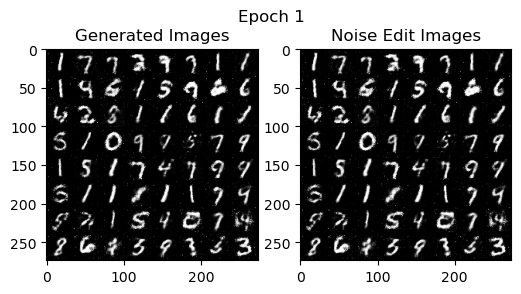

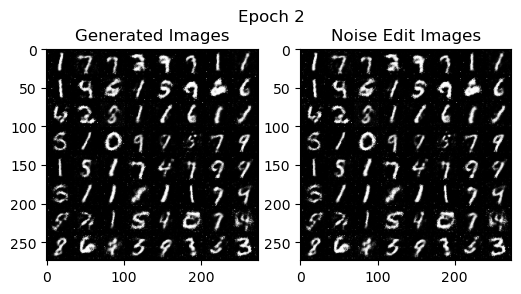

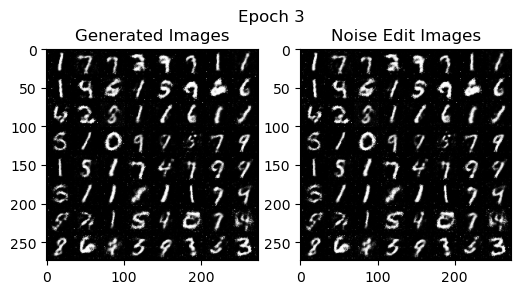

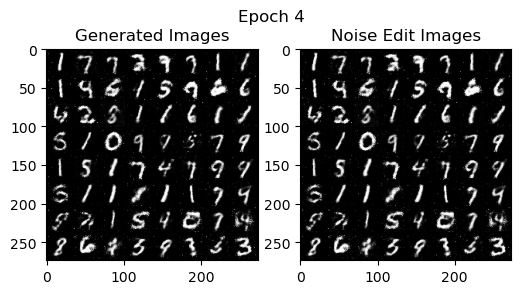

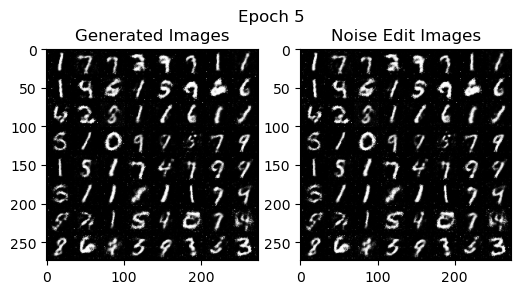

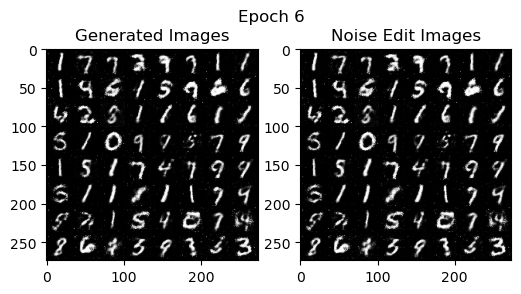

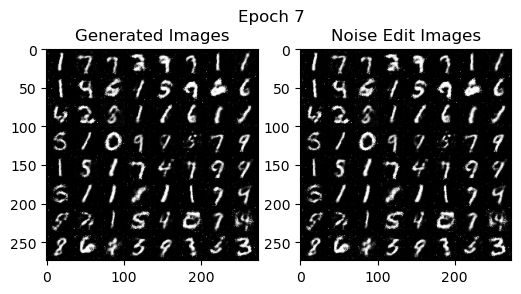

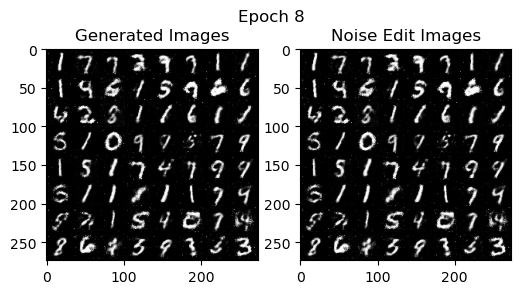

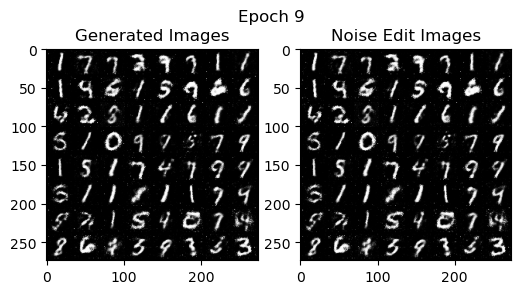

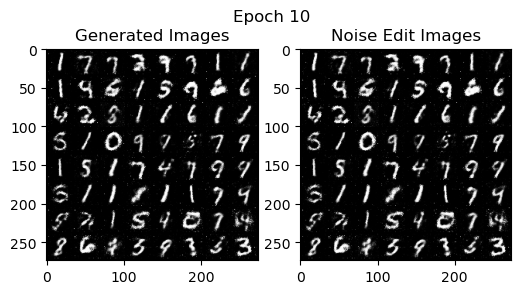

In [46]:
# Training loop
batch_num = 50
batch_size = 64
epochs = 10
device = torch.device("cuda")
walk_model.to(device)
generator.to(device)
discriminator.to(device)

torch.manual_seed(0)
fixed_noise = torch.randn(batch_size, latent_dim).to(device)
w_losses =[]


start = time.time()
for epoch in range(epochs):
    all_gen_z = torch.randn(batch_num * batch_size, latent_dim).to(device)
    for batch_start in range(0, len(all_gen_z), batch_size):
        cur_batch_size =batch_size
        alpha = 0.5
        
        # Train generator Walk model
        walk_model.zero_grad()
        noise = all_gen_z[batch_start:batch_start+batch_size] #z
        noise_image = generator(noise) #G(z)
        noise_image_edit = edit(noise_image, alpha) #edit(G(z), a)
        noise_edit = walk_model.forward(noise, alpha) # z + aw
        noise_edit_images = generator(noise_edit) #G(z + aw)
        
        w_loss = criterion_walk(noise_edit_images, noise_image_edit)
        w_loss.backward()
        optimizer_w.step()

        # Print progress
        if (batch_start / batch_size)%10 == 0:
            w_losses.append(w_loss)
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {batch_start}/{batch_num * batch_size}] [W loss: {w_loss.item()}]"
            )

    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        fake_images = make_grid(fake_images, normalize = True).cpu()
        noise_edit = walk_model.forward(fixed_noise, 1)
        noise_edit_images = generator(noise_edit)
        noise_edit_images = make_grid(noise_edit_images, normalize = True).cpu()
        # noise_edit_images = noise_edit_images - fake_images

        fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(6,3))
        fig.suptitle(f'Epoch {epoch + 1}')
        axs[0].set_title('Generated Images')
        axs[0].imshow(fake_images.permute(1, 2, 0))
        axs[1].set_title('Noise Edit Images')
        axs[1].imshow(noise_edit_images.permute(1, 2, 0))

end = time.time()
print(f'Finished Training after {end-start} s ')

torch.save(walk_model.state_dict(), "out/DCGAN/method3_walk_fix_gen")



[Epoch 0/1] [Batch 0/938] [D loss: 1.3738808631896973] [G loss: 3.2526278495788574] [W loss: 0.3193594217300415]
tensor([[-1.1258, -1.1524, -0.2506,  ..., -1.3602,  0.3446,  0.5199],
        [-2.6133, -1.6965, -0.2282,  ...,  0.8760, -0.2871,  1.0216],
        [-0.0744, -1.0922,  0.3920,  ...,  0.8200, -0.6332,  1.2948],
        ...,
        [ 0.6660, -2.0469,  0.5520,  ..., -0.2537, -1.4019,  0.7132],
        [-2.0824,  1.3060,  0.4853,  ...,  0.4989, -0.1217, -0.1090],
        [-0.6000, -1.3004,  0.6871,  ..., -0.7780,  0.5115, -0.5564]],
       device='cuda:0')
tensor([[ 1.5365, -3.0813, -0.0643,  ..., -4.8270,  0.0304, -3.9771],
        [ 2.0785, -4.5809,  1.2694,  ..., -4.2572,  0.7108, -1.7652],
        [ 2.5762, -3.8894, -0.5155,  ..., -4.0741, -0.8664, -0.7625],
        ...,
        [ 1.3957, -3.3786, -0.7416,  ..., -4.5565,  0.6635, -2.6108],
        [ 2.6371, -4.3981, -1.4315,  ..., -4.3727, -1.0626, -1.7674],
        [ 1.6279, -3.5007,  0.1991,  ..., -4.0984,  0.2265, -1.334

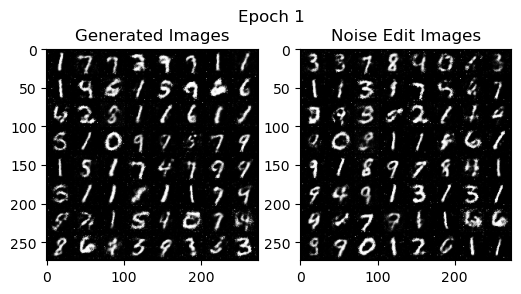

In [15]:
# Training loop
device = torch.device("cuda")
walk_model.to(device)
generator.to(device)
discriminator.to(device)

torch.manual_seed(0)
fixed_noise = torch.randn(batch_size, latent_dim).to(device)
w_losses =[]

start = time.time()
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device) #x
        cur_batch_size =len(real_images)
        alpha = 1
        real_labels = torch.ones(cur_batch_size, 1).to(device)
        fake_labels = torch.zeros(cur_batch_size, 1).to(device)

        # Train discriminator
        discriminator.zero_grad()

        real_images_edit = edit(real_images, alpha) #edit(x,a)
        real_edit_outputs = discriminator(real_images_edit) #D(edit(x,a))
        real_loss = criterion_GAN(real_edit_outputs, real_labels) #E(D(edit(x,a)))
        
        noise = torch.randn(cur_batch_size, latent_dim).to(device) #z
        noise_edit = walk_model.forward(noise, alpha) # z + aw
        noise_edit_images = generator(noise_edit) #G(z + aw)
        noise_edit_outputs = discriminator(noise_edit_images.detach()) #D(G(z+aw))
        fake_loss = criterion_GAN(noise_edit_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()


        # Train generator
        generator.zero_grad()
        noise = torch.randn(cur_batch_size, latent_dim).to(device) #z
        noise_edit = walk_model.forward(noise, alpha) # z + aw
        noise_edit_images = generator(noise_edit) #G(z + aw)
        fake_outputs = discriminator(noise_edit_images) #D(G(z + aw))

        g_loss = criterion_GAN(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()
        
        # Train generator Walk model
        walk_model.zero_grad()
        noise = torch.randn(cur_batch_size, latent_dim).to(device) #z
        noise_image = generator(noise) #G(z)
        noise_image_edit = edit(noise_image, alpha) #edit(G(z), a)
        noise_edit = walk_model.forward(noise, alpha) # z + aw
        noise_edit_images = generator(noise_edit) #G(z + aw)
        
        w_loss = criterion_walk(noise_edit_images, noise_image_edit)
        w_loss.backward()
        optimizer_w.step()

        # Print progress
        if i % 100 == 0:
            w_losses.append(w_loss)
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [W loss: {w_loss.item()}]"
            )
        break

    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        fake_images = make_grid(fake_images, normalize = True).cpu()
        print(fixed_noise)

        noise_edit = walk_model.forward(torch.randn(batch_size, latent_dim).to(device), 8)
        print(noise_edit)
        noise_edit_images = generator(noise_edit)
        noise_edit_images = make_grid(noise_edit_images, normalize = True).cpu()
        # noise_edit_images = noise_edit_images - fake_images

        fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(6,3))
        fig.suptitle(f'Epoch {epoch + 1}')
        axs[0].set_title('Generated Images')
        axs[0].imshow(fake_images.permute(1, 2, 0))
        axs[1].set_title('Noise Edit Images')
        axs[1].imshow(noise_edit_images.permute(1, 2, 0))

end = time.time()
print(f'Finished Training after {end-start} s ')

torch.save(walk_model.state_dict(), "out/DCGAN/method3_walk")
torch.save(generator.state_dict(), "out/DCGAN/method3_generator")
torch.save(discriminator.state_dict(), "out/DCGAN/method3_discriminator")

